In [ ]:
from collections import namedtuple, deque
import numpy as np

from tqdm import tqdm
import torch
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt
from copy import deepcopy
import collections
import imageio


import random
import wandb
import copy

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import MaxAndSkipObservation, ResizeObservation, GrayscaleObservation, FrameStackObservation, ReshapeObservation
from stable_baselines3.common.atari_wrappers import NoopResetEnv, MaxAndSkipEnv, FireResetEnv, EpisodicLifeEnv
import ale_py
import cv2
from gymnasium.spaces import Box

### Enviroment preparation

In [ ]:
# Name of the Enviroment to use
ENV_NAME = "ALE/Frogger-v5"

In [ ]:
class ScaledFloatFrame(gym.ObservationWrapper):
    """
    To scale the observation to 0-1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


def make_env(env_name):
    """
    Given the environment name, it returns the environment with all the wrappers applied.
    """
    env = gym.make(env_name, obs_type="grayscale", render_mode="rgb_array")
    print("Original Env.        : {}".format(env.observation_space.shape))
    env = MaxAndSkipObservation(env, skip=4)
    print("MaxAndSkipObservation: {}".format(env.observation_space.shape))
    env = ResizeObservation(env, (84, 84))
    print("ResizeObservation    : {}".format(env.observation_space.shape))
    env = FrameStackObservation(env, stack_size=4)
    print("FrameStackObservation: {}".format(env.observation_space.shape))
    env = ScaledFloatFrame(env)
    print("ScaledFloatFrame     : {}".format(env.observation_space.shape))

    return env


env = make_env(ENV_NAME)
print("\nAction space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Standard Env.        : (210, 160)
MaxAndSkipObservation: (210, 160)
ResizeObservation    : (84, 84)
FrameStackObservation: (4, 84, 84)
ScaledFloatFrame     : (4, 84, 84)

Action space is Discrete(5) 
Observation space is Box(0, 255, (4, 84, 84), uint8) 


### DQN with Some extensions

In [ ]:
class DuelingDQN(nn.Module):
    """
    Implentation of the Dueling DQN architecture
    """
    def __init__(self, input_shape, output_shape):
        """
        Args:
            input_shape (tuple): Shape of the input image
            output_shape (int): Number of actions
        """ 
        super(DuelingDQN, self).__init__()

        # Convolutional layers
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=5, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1600, 512),
            nn.ReLU()
        )

        # Value and Advantage layers
        self.value_prediction = nn.Linear(512, 1)
        self.advantage_prediction = nn.Linear(512, output_shape)


    def forward(self, x):
        # Generating the embedding
        embedding = self.net(x)
        # Value and Advantage prediction
        value = self.value_prediction(embedding)
        advantage = self.advantage_prediction(embedding)
        # Combining the value and advantage to get the Q-values
        q_values = value + advantage - advantage.mean(dim=-1).unsqueeze(-1)
        return q_values

### Rainbow DQN

In [ ]:
from torch.nn import functional as F
import math

class NoisyLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(NoisyLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Initialize mu (mean) parameters with uniform distribution
        mu_range = 1 / math.sqrt(in_features)
        self.mu_weight = nn.Parameter(torch.empty(out_features, in_features).uniform_(-mu_range, mu_range))
        self.mu_bias = nn.Parameter(torch.empty(out_features).uniform_(-mu_range, mu_range))

        # Initialize sigma (standard deviation) parameters with a small constant value
        sigma_init = 0.5 / math.sqrt(in_features)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))

        # Register buffers for noise
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        self.register_buffer("epsilon_bias", torch.zeros(out_features))

    def forward(self, x, noise_enabled=True):  # Add noise_enabled argument
        if noise_enabled:
            # Generate factorized Gaussian noise
            epsilon_in = torch.randn(self.in_features, device=x.device)
            epsilon_out = torch.randn(self.out_features, device=x.device)

            # Scale noise using the function described in the paper
            epsilon_w = torch.sign(epsilon_in) * torch.sqrt(torch.abs(epsilon_in))
            epsilon_b = torch.sign(epsilon_out) * torch.sqrt(torch.abs(epsilon_out))

            self.epsilon_weight = epsilon_out.unsqueeze(1) * epsilon_w.unsqueeze(0)
            self.epsilon_bias = epsilon_b

            # Apply noise to weights and biases
            weight = self.mu_weight + self.sigma_weight * self.epsilon_weight
            bias = self.mu_bias + self.sigma_bias * self.epsilon_bias
        else:
            # Use only learned parameters without noise
            weight = self.mu_weight
            bias = self.mu_bias

        return F.linear(x, weight, bias)

class DQN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(DQN, self).__init__()

        # -- Feature Extractor --
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=5, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1600, 512),
            nn.ReLU()
        )

        # -- Duelling DQN extension --
        self.value_prediction = NoisyLayer(512, 1)
        self.advantage_prediction = NoisyLayer(512, output_shape)

    def forward(self, x, noise_enabled=False):
        embedding = self.net(x)  # Feature Extractor

        value = self.value_prediction(embedding, noise_enabled=noise_enabled)  # Value
        advantage = self.advantage_prediction(embedding, noise_enabled=noise_enabled)  # Advantage

        q_values = value + advantage - advantage.mean(dim=-1).unsqueeze(-1)  # Get the Q values

        return q_values

### Evaluation and Gif generation

In [ ]:
def evaluate(env, net, device="cpu", n_games=10):
    rewards = []
    for _ in tqdm(range(n_games)):
        state = env.reset()[0]
        total_reward = 0.0
        while True:
            state_v = torch.tensor(np.array([state])).to(device)
            q_vals = net(state_v)
            _, action = torch.max(q_vals, dim=1)
            new_state, reward, terminated, truncated, _ = env.step(int(action.item()))
            total_reward += reward
            if terminated or truncated:
                break
            state = new_state
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

In [ ]:
def generate_gif(env, net, device="cpu"):
    state = env.reset()[0]
    frames = [env.render()]
    while True:
        state_v = torch.tensor(np.array([state])).to(device)
        q_vals = net(state_v)
        _, action = torch.max(q_vals, dim=1)
        new_state, _, terminated, truncated, _ = env.step(int(action.item()))
        frames.append(env.render())
        if terminated or truncated:
            print(truncated)
            break
        state = new_state
    return frames

### DQN with Some Extensions Evaluation

In [ ]:
# Create the environment
env = make_env(ENV_NAME)
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = DuelingDQN(env.observation_space.shape, env.action_space.n).to(device)
model.load_state_dict(torch.load("models/model_gamma_90_lr_0001_v2.pth"))

# Evaluate the model
mean_reward, std_reward, rewards = evaluate(env, model, device=device, n_games=100)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

Standard Env.        : (210, 160)
MaxAndSkipObservation: (210, 160)
ResizeObservation    : (84, 84)
FrameStackObservation: (4, 84, 84)
ScaledFloatFrame     : (4, 84, 84)


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]

Mean reward: 265.44, Std reward: 128.07383183148693


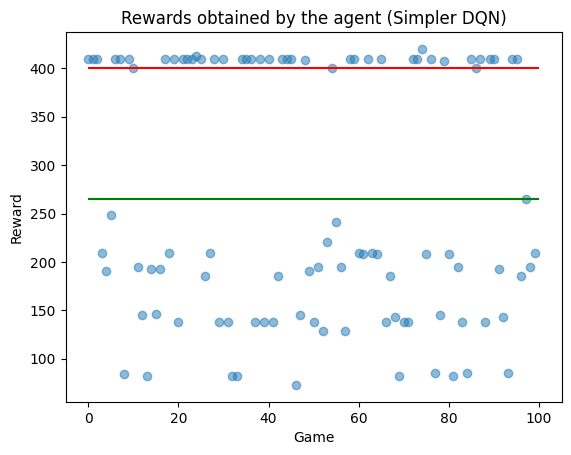

In [ ]:
# Visualize the rewards obtained
plt.scatter(range(len(rewards)), rewards, alpha=0.5, label="Rewards obtained")
plt.hlines(mean_reward, 0, len(rewards), color="green", label="Mean reward")
plt.hlines(400, 0, len(rewards), color="red", label="Treshold reward")
plt.xlabel("Game")
plt.ylabel("Reward")
plt.title("Rewards obtained by the agent (Simpler DQN)")
plt.show()

In [ ]:
# Generate the GIF
frames = generate_gif(env, model, device=device)

imageio.mimsave("frogger.gif", frames, duration=1/30)

### Rainbow evaluation

In [ ]:
# Load the model
rainbow = DQN(env.observation_space.shape, env.action_space.n).to(device)
rainbow.load_state_dict(torch.load(r"C:\Users\Joan\Downloads\Pong\model_lr_00001_gamma_99_v2.pt"))

# Evaluate the model
mean_reward, std_reward, rewards = evaluate(env, rainbow, device=device, n_games=100)

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


In [ ]:
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

Mean reward: 114.97, Std reward: 0.899499861033897


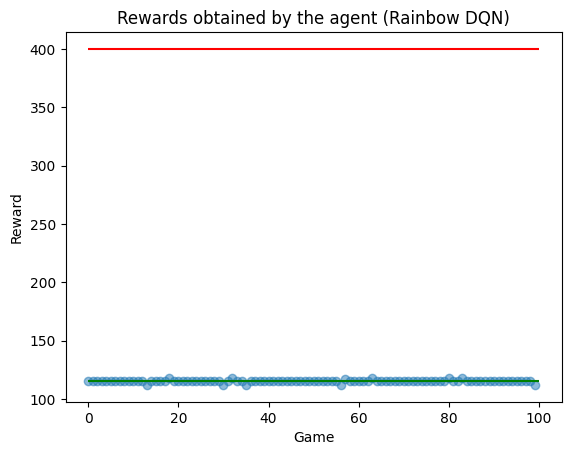

In [ ]:
# Visualize the rewards obtained
plt.scatter(range(len(rewards)), rewards, alpha=0.5, label="Rewards obtained")
plt.hlines(mean_reward, 0, len(rewards), color="green", label="Mean reward")
plt.hlines(400, 0, len(rewards), color="red", label="Treshold reward")
plt.xlabel("Game")
plt.ylabel("Reward")
plt.title("Rewards obtained by the agent (Rainbow DQN)")
plt.show()

In [ ]:
# Generate the GIF
frames = generate_gif(env, rainbow, device=device)

imageio.mimsave("frogger.gif", frames, duration=1/30)

False
